In [1]:
import numpy as np
import random
import copy
from icecream import ic
import inspect
import matplotlib.pyplot as plt

In [2]:
def safe_divide(a, b):
    return np.divide(a, b, out=np.zeros_like(a), where=b!=0)

def safe_log(x):
    return np.log(np.where(x > 0, x, 1))

def safe_sqrt(x):
    return np.sqrt(np.where(x >= 0, x, 0))

def safe_tan(x):
    return np.tan(np.where(np.abs(np.cos(x)) > 1e-6, x, 0))

def safe_exp(x, max_value=700):
    # Exponentially large values can overflow, so we clamp the input
    result = np.exp(np.clip(x, -max_value, max_value))
    return np.clip(result, -1e10, 1e10)


def safe_power(base, exponent, max_value=700, max_exponent=3):
    # Handle bases less than or equal to 0 when the exponent is fractional
    safe_base = np.where(base > 0, base, 1)

    # Clamp the exponent to avoid excessive growth
    exponent = np.clip(exponent, -max_exponent, max_exponent)

    # Compute power while avoiding overflow
    result = np.power(safe_base, exponent)

    # Handle edge cases: If base is 0 and exponent is non-positive
    result = np.where((base == 0) & (exponent <= 0), 1, result)

    return result

def safe_arcsin(x):
    # Clip the input to the range [-1, 1] to avoid invalid values
    x_clipped = np.clip(x, -1, 1)
    return np.arcsin(x_clipped)

def safe_arccos(x):
    # Clip the input to the range [-1, 1] to avoid invalid values
    x_clipped = np.clip(x, -1, 1)
    return np.arccos(x_clipped)


def safe_arctan(x, max_value=1000):
    # Clip the input to a reasonable range to avoid extreme values
    x_clipped = np.clip(x, -max_value, max_value)
    return np.arctan(x_clipped)







In [3]:
problem = np.load('../project-work/data/problem_7.npz')
x = problem['x']
y = problem['y']
print(x.shape, y.shape)

(2, 5000) (5000,)


In [4]:

OPERATORS = [np.add, np.subtract, np.multiply, safe_divide, np.sin, np.cos, safe_tan, safe_sqrt, safe_log, safe_exp, safe_power, safe_arcsin, safe_arccos, safe_arctan]

# Define the constants
constant_range = np.linspace(0.5, 10, num=30)
CONSTANTS = list(constant_range)
VARIABLES = [f'x{i}' for i in range(x.shape[0])]

In [5]:
class Node:
    def __init__(self, value, left=None, right=None):
        self.value = value
        self.left = left
        self.right = right

    def is_operator(self, operators):
        return self.value in operators

    def is_variable(self, variables):
        return self.value in variables

    def is_constant(self, constants):
        return self.value in constants

    def is_leaf(self):
        return self.left is None and self.right is None

    def __str__(self):
        if self.is_leaf():
            return str(self.value)
        if self.value in [np.sin, np.cos, safe_tan, safe_log, safe_sqrt, safe_exp, safe_arcsin, safe_arccos, safe_arctan] :
            return f"({self.value.__name__} {self.left})"
        return f"({self.left} {self.value.__name__} {self.right})"

class Tree:
    def __init__(self, root=None, operators=None, variables=None, constants=None):
        self.root = root
        self.operators = operators
        self.variables = variables
        self.constants = constants

    def evaluate(self, x, variable_values):
        return self._evaluate_node(self.root, x, variable_values)

    def _evaluate_node(self, node, x, variable_values):
        if node.is_operator(self.operators):
            if node.value in [np.sin, np.cos, safe_tan, safe_log, safe_sqrt, safe_exp, safe_arcsin, safe_arccos, safe_arctan]:
                return node.value(self._evaluate_node(node.left, x, variable_values))
            else:
                return node.value(self._evaluate_node(node.left, x, variable_values), self._evaluate_node(node.right, x, variable_values))
        elif node.is_variable(self.variables):
            return variable_values[node.value]
        elif node.is_constant(self.constants):
            return node.value
        
class Individual:
    def __init__(self, tree):
        self.tree = tree
        self.fitness = None

    def evaluate(self, x):
        variable_values = {f'x{i}': x[i] for i in range(x.shape[0])}
        return self.tree.evaluate(x, variable_values)
    
    def calculate_fitness(self, x, y):
        y_pred = []

        # Generate predictions for each sample in x
        for i in range(x.shape[1]):  # Iterate over samples
            sample = x[:, i]
            prediction = self.evaluate(sample)
            y_pred.append(prediction)

        # Convert y_pred to a NumPy array for consistent operations
        y_pred = np.array(y_pred)

        # Ensure the shapes of y_pred and y are the same
        if y_pred.shape != y.shape:
            print(f"Shape mismatch: y_pred.shape = {y_pred.shape}, y.shape = {y.shape}")

        # Calculate MSE
        mse_value = np.mean((y_pred - y) ** 2)

        # Store the fitness as the negative MSE for maximization purpose
        self.fitness = -mse_value
        return self.fitness

    @staticmethod
    def create_individual(num_nodes, operators, variables, constants):
        def create_random_tree(num_nodes):
            if num_nodes == 1:
                if random.random() < 0.5:
                    return Node(random.choice(variables))
                else:
                    return Node(random.choice(constants))
            else:
                operator = random.choice(operators)
                if operator in [np.sin, np.cos, safe_tan, safe_log, safe_sqrt, safe_exp, safe_arcsin, safe_arccos, safe_arctan]:
                    left_subtree_size = num_nodes - 1
                    return Node(operator, left=create_random_tree(left_subtree_size))
                else:
                    if num_nodes <= 2:
                        left_subtree_size = 1
                        right_subtree_size = num_nodes - 1
                    else:
                        left_subtree_size = random.randint(1, num_nodes - 2)
                        right_subtree_size = num_nodes - 1 - left_subtree_size
                    left_child = create_random_tree(left_subtree_size)
                    right_child = create_random_tree(right_subtree_size)
                    if operator == np.subtract and left_child.is_variable(variables):
                        right_child = Node(random.choice(constants))
                    if operator == safe_divide and left_child.is_variable(variables):
                        right_child = Node(random.choice(constants))
                                            
                    return Node(operator, left=left_child, right=right_child)

        tree = Tree(create_random_tree(num_nodes), operators, variables, constants)
        return Individual(tree)

    def __str__(self):
        return str(self.tree.root)


In [6]:
def fitness(individual):
    fitness_value = individual.calculate_fitness(x, y)
    complexity_value = get_tree_depth(individual.tree.root)
    return fitness_value 

def parents_selection(population, fitness_scores, tournament_size=5):
    selected = []
    for _ in range(len(population)):
        tournament = random.sample(list(zip(population, fitness_scores)), tournament_size)
        winner = max(tournament, key=lambda x: x[1])  # Select the best individual
        selected.append(winner[0])
    return selected

def get_random_node(node):
    non_leaf_nodes = []
    def traverse(n):
        if n is not None:
            if not n.is_leaf():
                non_leaf_nodes.append(n)
            traverse(n.left)
            traverse(n.right)
    traverse(node)
    return random.choice(non_leaf_nodes)

def get_tree_depth(node):
    if node is None:
        return 0
    return 1 + max(get_tree_depth(node.left), get_tree_depth(node.right))

def swap_subtrees(node1, node2):
    node1.value, node2.value = node2.value, node1.value
    node1.left, node2.left = node2.left, node1.left
    node1.right, node2.right = node2.right, node1.right

def recombine(parent1, parent2, min_depth=3, max_depth=9):
    # Deep copy the parents to avoid modifying the originals
    child1 = copy.deepcopy(parent1)
    child2 = copy.deepcopy(parent2)

    # Select random crossover points
    crossover_point1 = get_random_node(child1.tree.root)
    crossover_point2 = get_random_node(child2.tree.root)

    # Swap the subtrees at the crossover points
    swap_subtrees(crossover_point1, crossover_point2)
    
    if get_tree_depth(child1.tree.root) < min_depth or get_tree_depth(child1.tree.root) > max_depth:
        child1 = copy.deepcopy(parent1)
    if get_tree_depth(child2.tree.root) < min_depth or get_tree_depth(child2.tree.root) > max_depth:
        child2 = copy.deepcopy(parent2)

    return random.choice([child1, child2])

def mutate(individual, min_nodes=3):
    # Create a deep copy of the individual to avoid modifying the original
    mutated = copy.deepcopy(individual)

    # Get a random node to replace
    target_node = get_random_node(mutated.tree.root)
    target_node_depth = get_tree_depth(target_node)

    # Dynamically set the size of the new subtree based on the tree's overall depth
    if target_node_depth < 3:
        # For shallow nodes, generate a slightly larger subtree
        num_nodes = random.randint(3, 5)
    elif target_node_depth > 7:
        # For deeper nodes, limit the subtree size
        num_nodes = random.randint(2, 4)
    else:
        # For moderate nodes, allow moderate subtree sizes
        num_nodes = random.randint(3, 6)
        
    random_subtree = Individual.create_individual(num_nodes, OPERATORS, VARIABLES, CONSTANTS).tree.root

    # Replace the target node with the new subtree
    target_node.value = random_subtree.value
    target_node.left = random_subtree.left
    target_node.right = random_subtree.right

    # Ensure the resulting tree has at least `min_nodes` nodes
    if get_tree_depth(mutated.tree.root) < min_nodes:
        return individual  # Return the original individual if mutation fails

    return mutated


def select_next_generation(population, fitness_scores, offspring, offspring_fitness_scores, elite_fraction=0.05):
    # Combine population and fitness scores
    combined = list(zip(population + offspring, fitness_scores + offspring_fitness_scores))
    
    # Remove duplicates
    unique_combined = []
    seen = set()
    for ind, fit in combined:
        ind_str = str(ind.tree.root)
        if ind_str not in seen:
            seen.add(ind_str)
            unique_combined.append((ind, fit))
    
    # Sort by fitness (descending)
    unique_combined.sort(key=lambda x: x[1], reverse=True)
    
    # Preserve elites
    elite_count = int(elite_fraction * len(unique_combined))
    elites = unique_combined[:elite_count]
    next_population = [ind[0] for ind in elites]
    
    # Exclude elites from roulette wheel selection
    remaining_individuals = unique_combined[elite_count:]
    
    # Fill the rest of the population using roulette wheel selection
    total_fitness = sum(ind[1] for ind in remaining_individuals)
    if total_fitness > 0:
        probabilities = [ind[1] / total_fitness for ind in remaining_individuals]
        next_population += random.choices(
            [ind[0] for ind in remaining_individuals],
            weights=probabilities,
            k=len(population) - elite_count
        )
    else:
        # If total fitness is zero (edge case), pick randomly from remaining individuals
        next_population += random.sample(
            [ind[0] for ind in remaining_individuals],
            k=len(population) - elite_count
        )
    
    return next_population



In [7]:
# Create initial population
population_size = 100
population = [Individual.create_individual(6, OPERATORS, VARIABLES, CONSTANTS) for _ in range(population_size)]


# Calculate initial fitness scores
fitness_scores = [fitness(ind) for ind in population]

# Evolution process
num_generations = 50
for generation in range(num_generations):
    # Select parents
    parents = parents_selection(population, fitness_scores)
    
    # Create offspring
    offspring = []
    for _ in range(population_size // 2):
        parent1, parent2 = random.sample(parents, 2)     
        child = recombine(parent1, parent2)
        child = mutate(child)
        offspring.append(child)
    
    # Calculate fitness scores for offspring
    offspring_fitness_scores = [fitness(ind) for ind in offspring]
    
    # Select next generation
    population = select_next_generation(population, fitness_scores, offspring, offspring_fitness_scores)
           
    fitness_scores = [fitness(ind) for ind in population]

    # Print best fitness of the generation
    best_fitness = max(fitness_scores)
    best_indivual = population[fitness_scores.index(best_fitness)]
    print(f"Generation {generation}: Best Fitness = {best_fitness}, Best Individual = {best_indivual}")


Generation 0: Best Fitness = -716.5314031338721, Best Individual = (safe_log ((10.0 safe_power 2.4655172413793105) multiply 9.344827586206897))
Generation 1: Best Fitness = -702.3281001419916, Best Individual = ((x0 multiply x0) add 7.051724137931034)
Generation 2: Best Fitness = -702.3281001419916, Best Individual = ((x0 multiply x0) add 7.051724137931034)
Generation 3: Best Fitness = -702.3281001419916, Best Individual = ((x0 multiply x0) add 7.051724137931034)
Generation 4: Best Fitness = -702.3281001419916, Best Individual = ((x0 multiply x0) add 7.051724137931034)
Generation 5: Best Fitness = -702.3281001419916, Best Individual = ((x0 multiply x0) add 7.051724137931034)
Generation 6: Best Fitness = -702.3281001419916, Best Individual = ((x0 multiply x0) add 7.051724137931034)
Generation 7: Best Fitness = -702.0012621303875, Best Individual = ((x1 safe_power (safe_exp (safe_arccos ((safe_tan x1) safe_divide x0)))) add 7.051724137931034)
Generation 8: Best Fitness = -692.90152377018

KeyboardInterrupt: 

In [31]:
# Find and print the best individual and its final MSE on the validation set
best_individual = population[np.argmax(fitness_scores)]
final_mse = fitness(best_individual)

print(f"Best individual: {best_individual}")
print(f"Final MSE on validation set: {final_mse}")

Best individual: (x1 add (x1 add ((safe_arctan (safe_sqrt (safe_exp (((x0 safe_divide 2.1379310344827585) subtract x1) subtract 1.1551724137931034)))) subtract x0)))
Final MSE on validation set: -0.28204828072700494


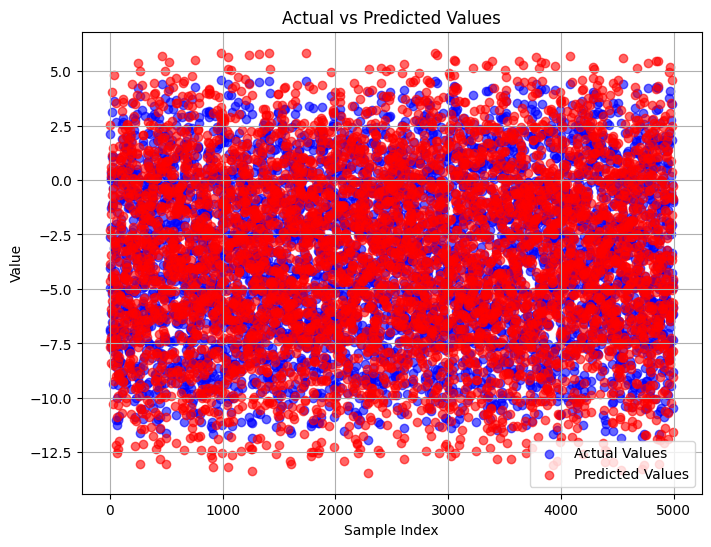

In [32]:
y_pred = []

# Generate predictions for each sample in x
for i in range(x.shape[1]):  # Iterate over samples
    sample = x[:, i]
    prediction = best_individual.evaluate(sample)
    y_pred.append(prediction)

# Convert y_pred to a NumPy array for consistent operations
y_pred = np.array(y_pred)

# Ensure the shapes of y_pred and y are the same
if y_pred.shape != y.shape:
    print(f"Shape mismatch: y_pred.shape = {y_pred.shape}, y.shape = {y.shape}")

# Plot actual values and predicted values with different colors
plt.figure(figsize=(8, 6))
plt.scatter(range(len(y)), y, color='blue', label='Actual Values', alpha=0.6)
plt.scatter(range(len(y_pred)), y_pred, color='red', label='Predicted Values', alpha=0.6)
plt.xlabel('Sample Index')
plt.ylabel('Value')
plt.title('Actual vs Predicted Values')
plt.legend()
plt.grid(True)
plt.show()